In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchinfo
import torchvision
from torch.utils.data import DataLoader
from torchlake.image_generation.controllers.trainer_pixelcnn import PixelCNNTrainer
from torchlake.common.utils.convert import img_tensor_to_np
from torchlake.common.utils.plot import plot_grids
from torchlake.common.utils.platform import get_num_workers
from torchlake.image_generation.models.gated_pixelcnn import GatedPixelCNN
from torchvision import transforms
from tqdm import tqdm

# Setting

In [2]:
IMAGE_SIZE = 32
BATCH_SIZE = 64

In [3]:
artifact_path = Path("../../artifacts/gated-pixelcnn")
artifact_path.mkdir(exist_ok=True)

data_path = Path("../../data/cifar10")

In [4]:
DEVICE = torch.device("cuda:0")

# Data

In [5]:
preprocess = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

In [6]:
train_data = torchvision.datasets.CIFAR10(
    root=data_path.as_posix(),
    train=True,
    transform=preprocess,
    download=True,
)

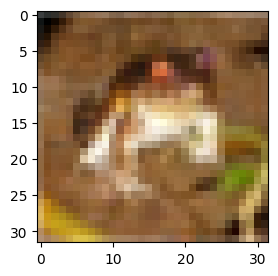

In [7]:
plt.figure(figsize=(3, 3))
plt.imshow(img_tensor_to_np(train_data[0][0]))

In [8]:
def collate_fn(batch):
    x, y = [], []
    for img, _ in batch:
        x.append(img)
        y.append(img)
        
    return torch.stack(x), torch.stack(y).mul_(255).long().view(-1, IMAGE_SIZE, IMAGE_SIZE)

In [9]:
train_loader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    pin_memory=True,
    collate_fn=collate_fn,
    num_workers=get_num_workers(),
)

In [10]:
for x, y in train_loader:
    print(x.shape, y.shape)
    break

torch.Size([64, 3, 32, 32]) torch.Size([192, 32, 32])


# Model

In [11]:
model = GatedPixelCNN(
    3,
    256,
    hidden_dim=128,
    num_layers=6,
)

In [12]:
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
GatedPixelCNN                            --
├─Sequential: 1-1                        --
│    └─MaskedConv2d: 2-1                 113,664
├─ModuleList: 1-2                        --
│    └─GatedLayer: 2-2                   --
│    │    └─Conv2d: 3-1                  1,770,240
│    │    └─Conv2d: 3-2                  295,680
│    │    └─Conv2d: 3-3                  590,592
│    │    └─MaskedConv2d: 3-4            590,592
│    │    └─MaskedConv2d: 3-5            295,680
│    │    └─MaskedConv2d: 3-6            147,840
│    └─GatedLayer: 2-3                   --
│    │    └─Conv2d: 3-7                  1,770,240
│    │    └─Conv2d: 3-8                  295,680
│    │    └─Conv2d: 3-9                  590,592
│    │    └─MaskedConv2d: 3-10           590,592
│    │    └─MaskedConv2d: 3-11           295,680
│    │    └─MaskedConv2d: 3-12           147,840
│    └─GatedLayer: 2-4                   --
│    │    └─Conv2d: 3-13                 1,770

In [13]:
model.blocks[0].conv_h.mask[:, :, :, :].sum(dim=(0, 1))

tensor([[294912., 196608.]])

In [14]:
model.foot[0].mask[:, :, :, :].sum(dim=(0, 1))

tensor([[2304., 2304., 2304., 2304., 2304., 2304., 2304.],
        [2304., 2304., 2304., 2304., 2304., 2304., 2304.],
        [2304., 2304., 2304., 2304., 2304., 2304., 2304.],
        [2304., 2304., 2304.,  768.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0.],
        [   0.,    0.,    0.,    0.,    0.,    0.,    0.]])

# train

In [15]:
EPOCH = 10

In [16]:
trainer = PixelCNNTrainer(EPOCH, DEVICE)

In [17]:
trainer.recorder.increment_data_size(len(train_data))

In [18]:
criterion = trainer.get_criterion(256)
optim = torch.optim.Adam(model.parameters(), lr=1e-4)

In [19]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, 'min', patience=2, threshold=.05 ,threshold_mode ='rel')

In [20]:
scaler = torch.amp.GradScaler()

In [21]:
training_loss = trainer.run(train_loader, model, optim, criterion, scheduler=scheduler, scaler=scaler)

Enable AMP: True
Training...


100%|██████████| 781/781 [05:31<00:00,  2.35it/s]


------------------------------------
Epoch 1
------------------------------------
0.06625585914611819 (0%)


100%|██████████| 781/781 [05:29<00:00,  2.37it/s]


------------------------------------
Epoch 2
------------------------------------
0.052993438711166393 (-20%)


100%|██████████| 781/781 [05:32<00:00,  2.35it/s]


------------------------------------
Epoch 3
------------------------------------
0.04653260894775397 (-12%)


100%|██████████| 781/781 [05:31<00:00,  2.35it/s]


------------------------------------
Epoch 4
------------------------------------
0.043218257350921545 (-7%)


100%|██████████| 781/781 [05:31<00:00,  2.35it/s]


------------------------------------
Epoch 5
------------------------------------
0.04135817214965822 (-4%)


100%|██████████| 781/781 [05:27<00:00,  2.38it/s]


------------------------------------
Epoch 6
------------------------------------
0.039988760199546794 (-3%)


100%|██████████| 781/781 [05:38<00:00,  2.31it/s]


------------------------------------
Epoch 7
------------------------------------
0.039024543218612644 (-2%)


100%|██████████| 781/781 [05:44<00:00,  2.27it/s]


------------------------------------
Epoch 8
------------------------------------
0.03813034845352177 (-2%)


100%|██████████| 781/781 [05:12<00:00,  2.50it/s]


------------------------------------
Epoch 9
------------------------------------
0.03747551833152767 (-2%)


100%|██████████| 781/781 [05:12<00:00,  2.50it/s]

------------------------------------
Epoch 10
------------------------------------
0.036747201285362276 (-2%)


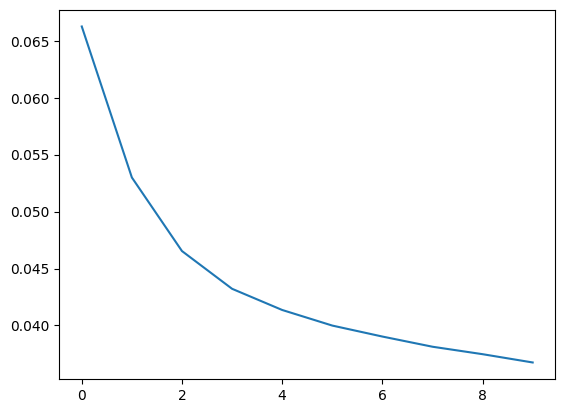

In [22]:
plt.plot(training_loss)

In [23]:
from torchlake.common.controller.weight_manager import WeightManager

manager = WeightManager(artifact_path.joinpath('gated-pixelcnn.d{hidden_dim}.l{num_layer}.cifar10.pth').as_posix())
model_path = manager.get_filename(hidden_dim=model.hidden_dim, num_layer=model.num_layers)

In [24]:
manager.save_weight(model.state_dict(), model_path)

Save weight to ..\..\artifacts\gated-pixelcnn\gated-pixelcnn.d128.l6.cifar10.pth, model size is 87.19MiB


In [25]:
manager.load_weight(model_path, model)

# evaluation

In [26]:
TEST_BATCH_SIZE = 16

In [27]:
import numpy as np

3072it [00:55, 55.84it/s]


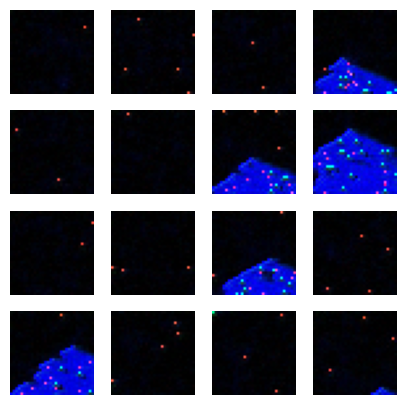

In [ ]:
from itertools import product


model.eval()
with torch.no_grad():
    placeholder = torch.zeros(TEST_BATCH_SIZE, 3, IMAGE_SIZE, IMAGE_SIZE).to(DEVICE)
    
    for i, j, c in tqdm(product(range(IMAGE_SIZE), range(IMAGE_SIZE), range(3))):
        # only subsecond level speed up for smaller placeholder
        dist = model(placeholder[:, :, :(i+1)])[:, c, :, i, j].softmax(1)
        placeholder[:, c, i, j] = torch.multinomial(dist, 1).squeeze_(-1).float() / 255.0
                
plot_grids(
    # img_tensor_to_np(placeholder, scale=255, output_type=np.uint8), 
    img_tensor_to_np(placeholder), 
    num_col=4,
    num_row=4,
    figsize=(5,5),
)